In [2]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(caret)
install.packages("e1071")

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘testthat’

The following object is masked from ‘package:dplyr’:

    matches

The following object is masked from ‘package:purrr’:

    is_null

Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


Reading the data into R using read.csv with a comma delimiter. 

In [3]:
red_data <- read.csv("winequality-red.csv", sep = ";") 
head(red_data)

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5


The data is already tidy, so there is no need to do anything to it.

Partitioning the data into training and testing sets. 

In [4]:
set.seed(100)

training_set <- red_data %>% 
    select(quality) %>% 
    unlist() %>% 
    createDataPartition(p = 0.75, list = FALSE)

X_train <- red_data %>% 
    select(-density, -quality) %>% 
    slice(training_set) %>% 
    data.frame()

Y_train <- red_data %>% 
    select(quality) %>% 
    slice(training_set) %>% 
    unlist()

X_test <- red_data %>% 
    select(-density, -quality) %>% 
    slice(-training_set) %>% 
    data.frame()

Y_test <- red_data %>% 
    select(quality) %>% 
    slice(-training_set) %>% 
    unlist()

citric <- red_data %>% 
    select(citric.acid) %>% 
    min() %>% 
    max() %>% 
    mean() %>% 
    median()

citric <- red_data %>% 
    select(citric.acid) %>% 
    max()


Selecting the best value of k to use.

In [5]:
train_control <- trainControl(method = "cv", number = 10)
k = data.frame(k = seq(from = 1, to = 100, by = 1))

knn <- train(x = X_train, y = Y_train, method = "knn", tuneGrid = k, trControl = train_control)
knn

k-Nearest Neighbors 

1200 samples
  10 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1080, 1080, 1080, 1079, 1080, 1080, ... 
Resampling results across tuning parameters:

  k    RMSE       Rsquared    MAE      
    1  0.8622696  0.17627422  0.5333063
    2  0.7869634  0.17569629  0.5595983
    3  0.7713734  0.16383159  0.5710962
    4  0.7648516  0.15536581  0.5796962
    5  0.7515361  0.16144076  0.5778731
    6  0.7474851  0.16131368  0.5793297
    7  0.7471562  0.15843604  0.5798052
    8  0.7487238  0.15262095  0.5818425
    9  0.7457168  0.15364922  0.5774423
   10  0.7448809  0.15168333  0.5797007
   11  0.7420889  0.15596624  0.5790597
   12  0.7406330  0.15845307  0.5793459
   13  0.7425765  0.15331659  0.5813389
   14  0.7403749  0.15687714  0.5781765
   15  0.7419765  0.15311638  0.5792016
   16  0.7428998  0.15032830  0.5810589
   17  0.7421178  0.15260770  0.5810477
   18  0.7406806  0.15536631  0.5812315
   19  0.7416701  0.

The plot of k vs RMSE

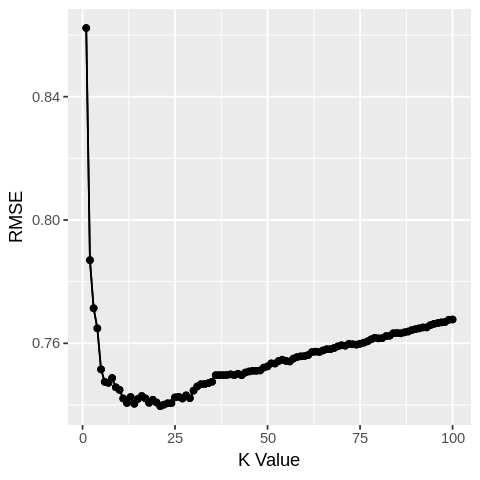

In [6]:
options(repr.plot.width = 4, repr.plot.height = 4)

k_accuracies <- knn$results

RMSE_plot <- knn %>% 
    ggplot(aes(x = k, y = RMSE)) + 
    geom_point() +
    geom_line() +
    xlab("K Value") + 
    ylab("RMSE")

RMSE_plot

We will select k = 21 to train our model because k is the smallest k value that give the smallest RMSE.

In [7]:
k_best <- data.frame(k = 7)
knn_red <- train(x = X_train, y = Y_train, method = "knn", tuneGrid = k_best)
knn_red

k-Nearest Neighbors 

1200 samples
  10 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1200, 1200, 1200, 1200, 1200, 1200, ... 
Resampling results:

  RMSE     Rsquared   MAE      
  0.78228  0.1191443  0.6005299

Tuning parameter 'k' was held constant at a value of 7

Testing the model onto the test data.

In [8]:
k <- data.frame(k = 21)
knn_21 <- train(x = X_train, y = Y_train, method = "knn", tuneGrid = k)

test <- predict(knn_21, X_test)

predictions <- data.frame(obs = Y_test, pred = test)

head(predictions, n = 10)

,obs,pred
quality1,5,5.476190
quality2,5,5.428571
quality3,5,5.363636
quality4,5,5.428571
quality5,5,5.523810
quality6,7,5.285714
quality7,4,5.476190
quality8,5,5.476190
quality9,5,5.333333
quality10,6,5.590909


In [9]:
test_error <- defaultSummary(predictions)
test_error

RMSE  Rsquared       MAE 
0.7500920 0.1735361 0.5864421

The min and max wine qualities in the testing set. 

In [10]:
min(Y_test)
max(Y_test)

error_ratio <- 0.750092009457794/(8-3)
error_ratio

[1] 3

[1] 8

[1] 0.1500184

Let's try to reduce this error. 

In [11]:
red_data_new <- red_data %>% 
    mutate(acidity.ratio = volatile.acidity/fixed.acidity) %>% 
    mutate(sulfur.dioxide.ratio = free.sulfur.dioxide/total.sulfur.dioxide) %>% 
    mutate(alcohol.percent = alcohol / 100) %>%
    select(residual.sugar, chlorides, pH, sulphates, acidity.ratio, sulfur.dioxide.ratio, alcohol.percent, quality)

red_scaled <- red_data_new %>% 
  select(-quality) %>% 
  scale(center = FALSE) 

red_scaled <- data.frame(quality = red_data_new$quality, red_scaled)


head(red_scaled)

quality,residual.sugar,chlorides,pH,sulphates,acidity.ratio,sulfur.dioxide.ratio,alcohol.percent
5,0.6541052,0.7649761,1.0585855,0.8237400,1.2983699,0.7841759,0.8968984
5,0.8950914,0.9864165,0.9650922,1.0002557,1.5485320,0.9044091,0.9350642
5,0.7918116,0.9260236,0.9831877,0.9561268,1.3373685,0.6732824,0.9350642
6,0.6541052,0.7549106,0.9530286,0.8531593,0.3431406,0.6867480,0.9350642
5,0.6541052,0.7649761,1.0585855,0.8237400,1.2983699,0.7841759,0.8968984
5,0.6196787,0.7549106,1.0585855,0.8237400,1.2241773,0.7877404,0.8968984


In [12]:
scaled_training <- red_scaled %>% 
    select(quality) %>% 
    unlist() %>% 
    createDataPartition(p = 0.75, list = FALSE)

X_train_scaled <- red_scaled %>% 
    select(-quality) %>% 
    slice(scaled_training) %>% 
    data.frame()

Y_train_scaled <- red_scaled %>% 
    select(quality) %>% 
    slice(scaled_training) %>% 
    unlist()

X_test_scaled <- red_scaled %>% 
    select(-quality) %>% 
    slice(-scaled_training) %>% 
    data.frame()

Y_test_scaled <- red_scaled %>% 
    select(quality) %>% 
    slice(-scaled_training) %>% 
    unlist()


In [13]:
train_control <- trainControl(method = "cv", number = 10)
k = data.frame(k = seq(from = 1, to = 100, by = 1))

knn_scaled <- train(x = X_train_scaled, y = Y_train_scaled, method = "knn", tuneGrid = k, trControl = train_control)
knn_scaled

k-Nearest Neighbors 

1200 samples
   7 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1080, 1080, 1079, 1081, 1079, 1080, ... 
Resampling results across tuning parameters:

  k    RMSE       Rsquared   MAE      
    1  0.8172561  0.2362216  0.4892225
    2  0.7315586  0.2627760  0.5112246
    3  0.7064718  0.2756695  0.5158191
    4  0.6940732  0.2823546  0.5208362
    5  0.6934413  0.2782345  0.5272258
    6  0.6930565  0.2747148  0.5347977
    7  0.6957543  0.2673089  0.5409992
    8  0.6917114  0.2712345  0.5380810
    9  0.6899355  0.2736233  0.5390304
   10  0.6901013  0.2725102  0.5396278
   11  0.6871285  0.2775392  0.5403957
   12  0.6845870  0.2822221  0.5395412
   13  0.6822220  0.2868489  0.5372141
   14  0.6818967  0.2875368  0.5387511
   15  0.6804674  0.2913263  0.5377497
   16  0.6820762  0.2870026  0.5407308
   17  0.6814840  0.2890714  0.5405789
   18  0.6830342  0.2864845  0.5426574
   19  0.6835582  0.2858134  0.5436735


In [14]:
k_best_scaled = data.frame(k = 26)

knn_scaled <- train(x = X_train_scaled, y = Y_train_scaled, method = "knn", tuneGrid = k_best_scaled)

knn_scaled


k-Nearest Neighbors 

1200 samples
   7 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1200, 1200, 1200, 1200, 1200, 1200, ... 
Resampling results:

  RMSE       Rsquared  MAE      
  0.6924878  0.251399  0.5533574

Tuning parameter 'k' was held constant at a value of 26

,obs,pred
quality1,7,5.346154
quality2,5,5.615385
quality3,5,5.461538
quality4,7,5.923077
quality5,6,5.500000
quality6,5,5.500000
quality7,6,5.615385
quality8,5,5.769231
quality9,4,5.192308
quality10,5,5.500000


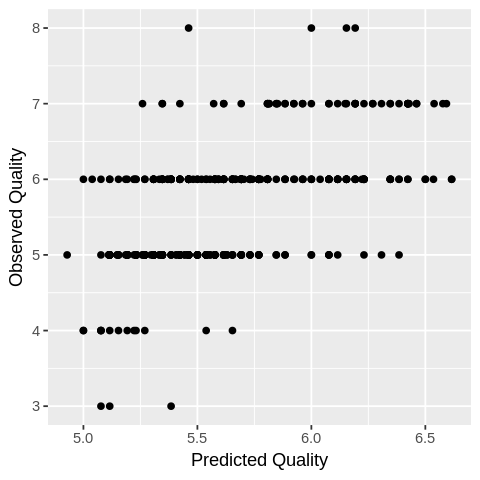

In [15]:
k <- data.frame(k = 26)

knn_final_s <- train(x = X_train_scaled, y = Y_train_scaled, method = "knn", tuneGrid = k)

test_scaled <- predict(knn_final_s, X_test_scaled)

predictions_scaled <- data.frame(obs = Y_test_scaled, pred = test_scaled)

head(predictions_scaled, n = 10)

plot <- predictions_scaled %>% 
    ggplot(aes(x = pred, y = obs)) +
    geom_point() + 
    xlab("Predicted Quality") + 
    ylab("Observed Quality")

plot

In [16]:
test_error <- defaultSummary(predictions_scaled)
test_error

error_ratio <- 0.671133163073198/(8-3)
error_ratio

RMSE  Rsquared       MAE 
0.6683576 0.3254615 0.5384445

[1] 0.1342266

# Ivan's Workspace

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5


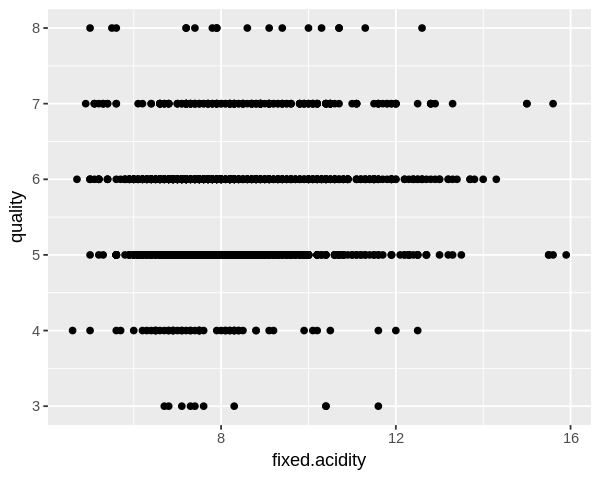

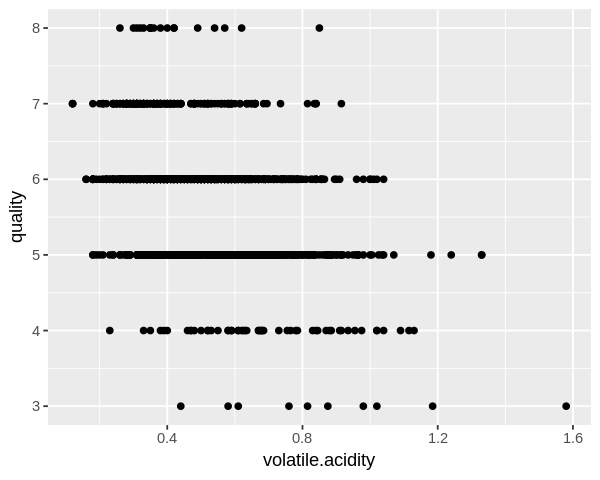

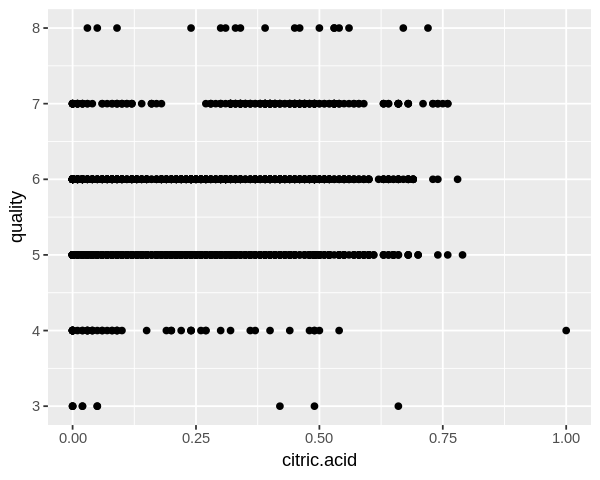

In [17]:
#fixed.acidity volatile.acidity citric.acid residual.sugar chlorides free.sulfur.dioxide total.sulfur.dioxide density pH sulphates alcohol quality
options(repr.plot.width = 5, repr.plot.height = 4)

head(red_data)

plot_fa <- red_data %>% 
    ggplot(aes(x = fixed.acidity, y = quality)) + 
    geom_point()
plot_fa

plot_va <- red_data %>% 
    ggplot(aes(x = volatile.acidity, y = quality)) +
    geom_point()
plot_va

plot_ca <- red_data %>% 
    ggplot(aes(x = citric.acid, y = quality)) +
    geom_point()
plot_ca
    

# Yeying's Workspace

In [18]:
# Working on three variables: chlorides,free.sulfur.dioxide	,total.sulfur.dioxide

In [19]:
install.packages("GGally")
library(GGally)

also installing the dependencies ‘progress’, ‘reshape’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done

Attaching package: ‘GGally’

The following object is masked from ‘package:dplyr’:

    nasa



In [4]:
# Import white wine data
white_data <- read.csv("winequality-white.csv", sep = ";")
head(white_data)

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
7.0,0.27,0.36,20.7,0.045,45,170,1.0010,3.00,0.45,8.8,6
6.3,0.30,0.34,1.6,0.049,14,132,0.9940,3.30,0.49,9.5,6
8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6
7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6
7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6
8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6


In [21]:
# See the rough distribution of quality level
red_data %>% 
    group_by(quality) %>%
    summarize(n = n())
white_data %>%
    group_by(quality) %>%
    summarize(n=n())

quality,n
3,10
4,53
5,681
6,638
7,199
8,18


quality,n
3,20
4,163
5,1457
6,2198
7,880
8,175
9,5


We can easily see that the data of quality is imbalanced.

In [22]:
#See the relationship between quality and the three variables
red_var <- red_data %>%
    select(chlorides:total.sulfur.dioxide, quality) 
red_var$quality <- as.factor(red_var$quality)

white_var <- white_var %>%
    select(chlorides:total.sulfur.dioxide, quality) 
white_var$quality <- as.factor(white_var$quality)

ggpairs(red_var, mapping = ggplot2::aes(colour = quality))
ggpairs(white_var, mapping = ggplot2::aes(colour = quality))


ERROR: Error in eval(lhs, parent, parent): object 'white_var' not found


In [ ]:
# Scaled the variables
red_scaled_var <- red_var %>%
    mutate(scaled_chlorides = scale(chlorides, center = FALSE),scaled_free.sulfur.dioxide = scale(free.sulfur.dioxide, center = FALSE),scaled_total.sulfur.dioxide = scale(total.sulfur.dioxide	, center = FALSE))%>%
    select(scaled_chlorides:scaled_total.sulfur.dioxide, quality) 
red_scaled_var$scaled_chlorides <- as.vector( red_scaled_var$scaled_chlorides )

glimpse(red_scaled_var)

white_scaled_var <- white_var %>%
    mutate(scaled_chlorides = scale(chlorides, center = FALSE),scaled_free.sulfur.dioxide = scale(free.sulfur.dioxide, center = FALSE),scaled_total.sulfur.dioxide = scale(total.sulfur.dioxide	, center = FALSE)) %>%
    select(scaled_chlorides:scaled_total.sulfur.dioxide, quality) 
glimpse(white_scaled_var)


Next, plot the scaled variables against quality

In [ ]:
# Red wine 
options(repr.plot.width = 4, repr.plot.height = 3)

r_scaled_chlorides_plot <- red_scaled_var %>%
    ggplot(aes(x = quality,y = scaled_chlorides)) +
    geom_point()
r_scaled_chlorides_plot

r_scaled_free.sulfur.dioxide_plot <- red_scaled_var %>%
    ggplot(aes(x = quality,y = scaled_free.sulfur.dioxide)) +
    geom_point()
r_scaled_free.sulfur.dioxide_plot

r_scaled_total.sulfur.dioxide_plot <- red_scaled_var %>%
    ggplot(aes(x = quality,y = scaled_total.sulfur.dioxide)) +
    geom_point()
r_scaled_total.sulfur.dioxide_plot






In [ ]:
options(repr.plot.width = 4, repr.plot.height = 3)

# White wine 

w_scaled_chlorides_plot <- white_scaled_var %>%
    ggplot(aes(x = quality,y = scaled_chlorides)) +
    geom_point()
w_scaled_chlorides_plot

w_scaled_free.sulfur.dioxide_plot <- white_scaled_var %>%
    ggplot(aes(x = quality,y = scaled_free.sulfur.dioxide)) +
    geom_point()
w_scaled_free.sulfur.dioxide_plot

w_scaled_total.sulfur.dioxide_plot <- white_scaled_var %>%
    ggplot(aes(x = quality,y = scaled_total.sulfur.dioxide)) +
    geom_point()
w_scaled_total.sulfur.dioxide_plot


In [ ]:
head(red_data_new)

In [ ]:
# Try new variable sulfur dioxide ratio 
# use red_data_new 
ggplot(red_data_new,aes(x = quality, y = sulfur.dioxide.ratio)) +
    geom_point()


# Prayansh's Workspace

In [23]:
head(red_data)
head(white_data)

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5


fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
7.0,0.27,0.36,20.7,0.045,45,170,1.0010,3.00,0.45,8.8,6
6.3,0.30,0.34,1.6,0.049,14,132,0.9940,3.30,0.49,9.5,6
8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6
7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6
7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6
8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6


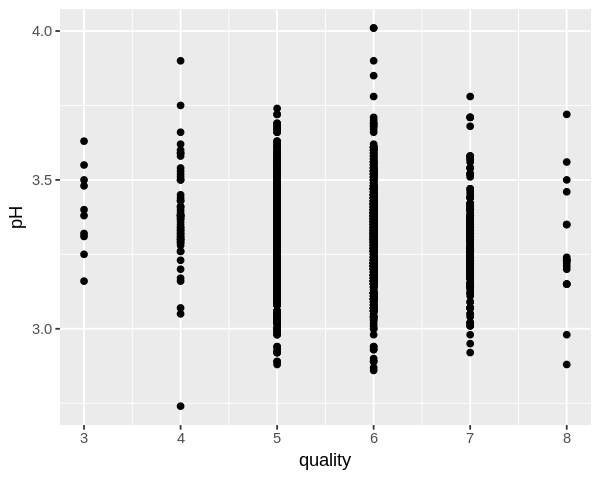

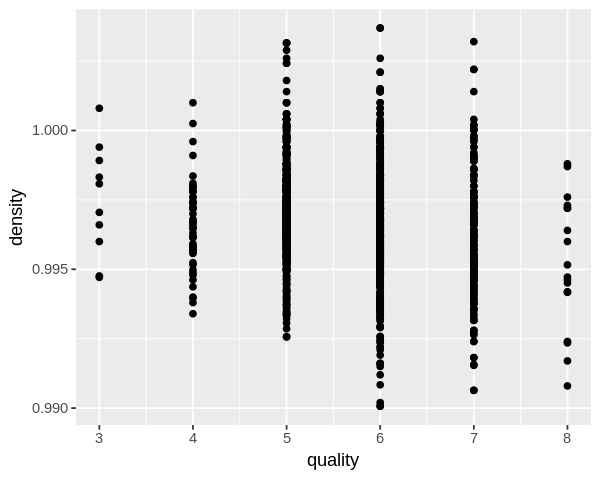

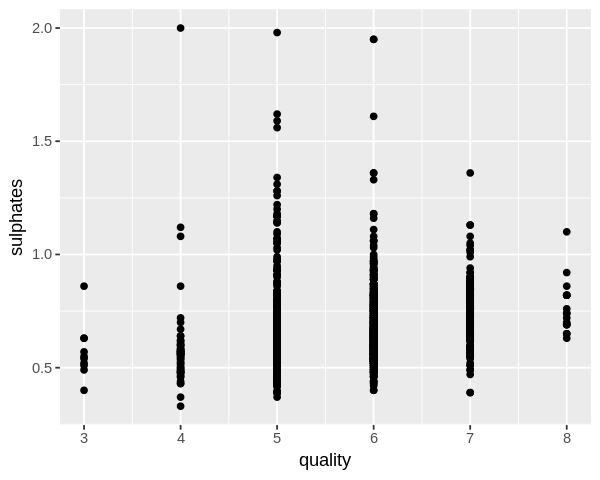

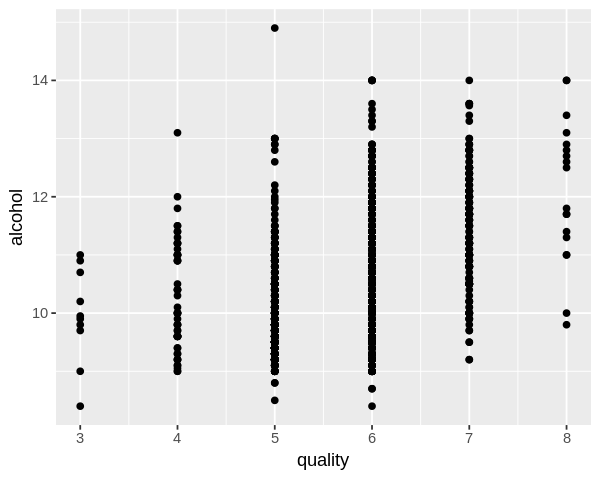

In [27]:
plot_ph_quality <- red_data %>% 
    ggplot(aes(x=quality, y=pH)) +
    geom_point()
plot_ph_quality
plot_density_quality <- red_data %>% 
    ggplot(aes(x=quality, y=density)) +
    geom_point()
plot_density_quality
plot_sulphates_quality <- red_data %>% 
    ggplot(aes(x=quality, y=sulphates)) +
    geom_point()
plot_sulphates_quality
plot_alcohol_quality <- red_data %>% 
    ggplot(aes(x=quality, y=alcohol)) +
    geom_point()
plot_alcohol_quality

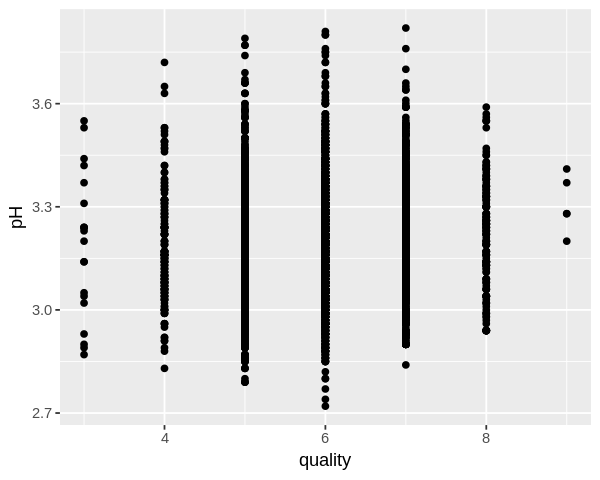

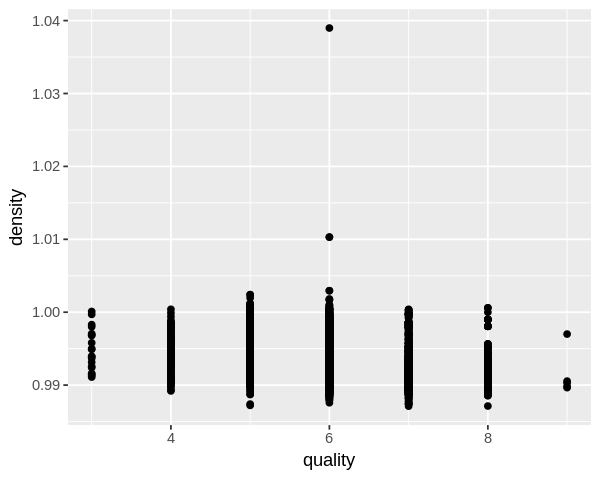

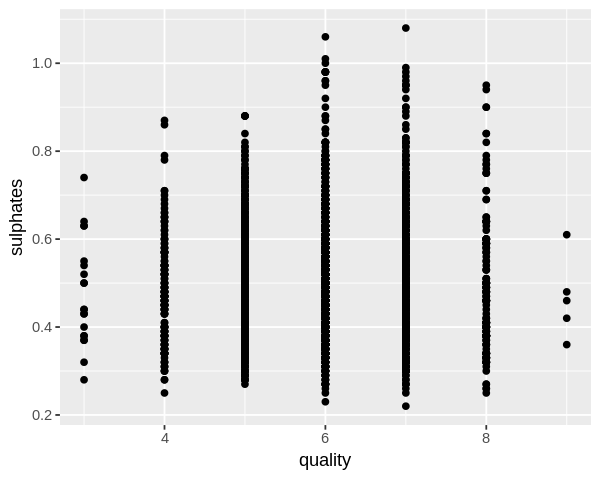

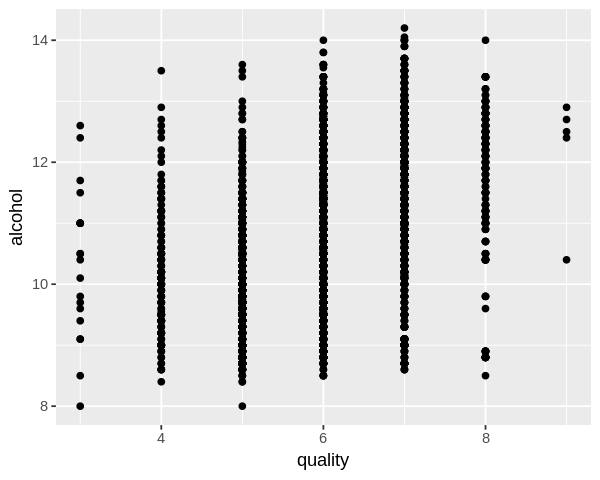

In [34]:
plot_ph_quality_white <- white_data %>% 
    ggplot(aes(x=quality, y=pH)) +
    geom_point()
plot_ph_quality_white
plot_density_quality_white <- white_data %>% 
    ggplot(aes(x=quality, y=density)) +
    geom_point()
plot_density_quality_white
plot_sulphates_quality_white <- white_data %>% 
    ggplot(aes(x=quality, y=sulphates)) +
    geom_point()
plot_sulphates_quality_white
plot_alcohol_quality_white <- white_data %>% 
    ggplot(aes(x=quality, y=alcohol)) +
    geom_point()
plot_alcohol_quality_white

# Plotting data using BoxPlot

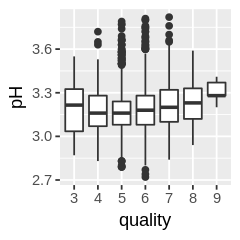

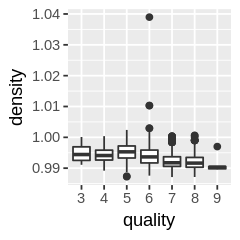

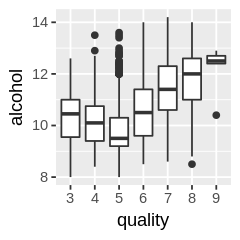

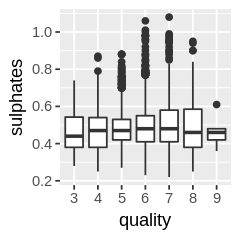

In [16]:
white_data_quality_factor <- white_data %>% mutate(quality = as.factor(quality))
options(repr.plot.width = 2, repr.plot.height = 2)
white_data_quality_factor %>% 
    ggplot(aes(x=quality, y=pH)) +
    geom_boxplot()
white_data_quality_factor %>% 
    ggplot(aes(x=quality, y=density)) +
    geom_boxplot()
white_data_quality_factor %>% 
    ggplot(aes(x=quality, y=alcohol)) +
    geom_boxplot()
white_data_quality_factor %>% 
    ggplot(aes(x=quality, y=sulphates)) +
    geom_boxplot()